In [2]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from urllib.parse import urljoin

# Base URL for relative links
BASE_URL = "https://lostpedia.fandom.com"

# URL of the first transcript page
start_url = "https://lostpedia.fandom.com/wiki/Pilot,_Part_1_transcript"

# Function to extract transcript links
def get_transcript_links(start_url):
    response = requests.get(start_url)
    soup = BeautifulSoup(response.text, "html.parser")

    # Find navbox tables that contain episode links
    transcript_links = []
    for td in soup.find_all("td", class_=re.compile(r"navbox-list")):
        for a_tag in td.find_all("a", href=True):
            href = a_tag["href"]
            if "transcript" in href.lower():  # Ensure it's a transcript link
                full_url = urljoin(BASE_URL, href)  # Convert to absolute URL
                transcript_links.append(full_url)
    
    return transcript_links

# Function to extract dialogue word counts from a transcript page
def extract_dialogue_data(url, character_word_count):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    paragraphs = soup.find_all("p")
    dialogue_pattern = re.compile(r"^([A-Z]+):\s*(.+)$")

    for p in paragraphs:
        text = p.get_text(strip=True)
        match = dialogue_pattern.match(text)
        if match:
            character = match.group(1)
            dialogue = match.group(2)

            words = re.findall(r"\b\w+(?:'\w+)?\b", dialogue.lower())  
            for word in words:
                character_word_count[character][word] += 1

# Dictionary to store word counts
character_word_count = defaultdict(lambda: defaultdict(int))

# Extract and process transcript links
transcript_links = get_transcript_links(start_url)
print(f"Found {len(transcript_links)} transcript links. Processing...")

# Process the first page (Pilot, Part 1)
extract_dialogue_data(start_url, character_word_count)

# Process additional transcript pages
for link in transcript_links:
    extract_dialogue_data(link, character_word_count)

# Convert data to Pandas DataFrame
data = []
for character, word_dict in character_word_count.items():
    for word, count in word_dict.items():
        data.append([character, word, count])

df = pd.DataFrame(data, columns=["Character", "Word", "Count"])

print("Finished")


Found 259 transcript links. Processing...


In [12]:
from stop_words import get_stop_words

def generate_word_cloud(character):
    stop_words = set(get_stop_words('english'))
    stop_words.add("subtitle")
    
    char_data = df[df["Character"] == character]
    char_data_pruned = char_data[~char_data["Word"].isin(stop_words)]
    if char_data_pruned.empty:
        print(f"No dialogue found for {character}.")
        return
    
    word_freq = {row["Word"]: row["Count"] for _, row in char_data_pruned.iterrows()}
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {character}", fontsize=14)
    plt.show()


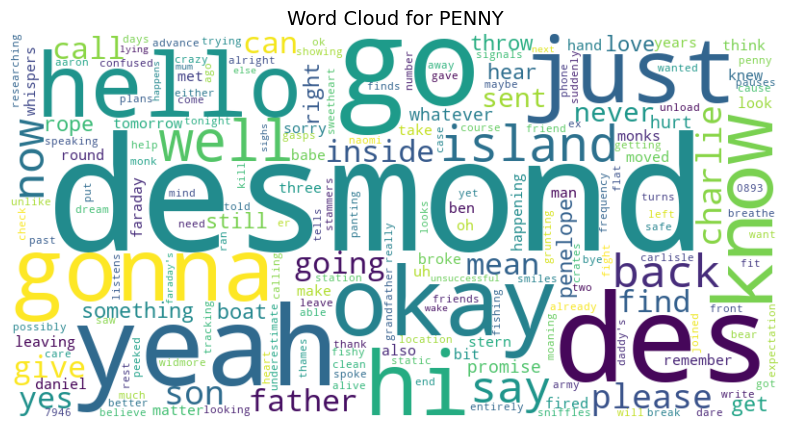

In [24]:
generate_word_cloud('PENNY')